# Political Sentiment Analysis using Tensorflow (English)
---
By Tan Vee Han

Supervisor Dr. Victor Tan Hock Kim

## Loading and cleaning dataset

In [1]:
# importing libraries
%matplotlib inline
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from random import shuffle
import re
import tensorflow as tf
import time
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from tflearn.data_utils import VocabularyProcessor


c:\users\cloud\appdata\local\conda\conda\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
c:\users\cloud\appdata\local\conda\conda\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
# Change the file locaton according to the location you stored the dataset
file = r'ch_data.csv'

In [3]:
# reading raw dataset
raw_data = pd.read_csv(file, encoding = "utf-8-sig")

# Cloning the dataset
data = raw_data

In [4]:
data.groupby('semantic_value')['_id'].nunique()

semantic_value
negative    466
neutral     390
positive    331
Name: _id, dtype: int64

### Cleaning dataset

In [5]:
# Calculating number of alphabertic words in a dataset
data['word_count'] = data.value.apply(lambda x: len(x))
filter_data = data

## Seperating dataset

In [6]:
# Gathering labeled data
pos_val = filter_data[filter_data.semantic_value == "positive"]
neg_val = filter_data[filter_data.semantic_value == "negative"]
neu_val = filter_data[filter_data.semantic_value == "neutral"]

# Spliting into train and test dataset
train_set = pd.concat([pos_val[:333], neg_val[:333], neu_val[:333]])
test_set = pd.concat([pos_val[333:], neg_val[333:], neu_val[333:]])

In [7]:
# Print dataset Info
print("Total number of valid dataset:", filter_data.loc[filter_data.semantic_value != "unassigned",'_id'].count())
print("Total number of train dataset:", train_set._id.count())
print("Total number of test dataset:", test_set._id.count())

Total number of valid dataset: 157709
Total number of train dataset: 997
Total number of test dataset: 190


### Graphs

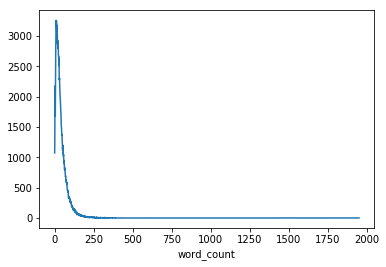

In [8]:
# Word count across the dataset
filter_data.groupby('word_count')['_id'].count().plot()

In [9]:
filter_data['word_count'].describe()

count    157709.000000
mean         41.732336
std          44.514157
min           1.000000
25%          16.000000
50%          30.000000
75%          54.000000
max        1949.000000
Name: word_count, dtype: float64

## Processing Dataset

In [10]:
# Define dataset size
data_set_size = 300

In [11]:
# Load data into list
train_pos = train_set.loc[train_set.semantic_value == "positive", "value"].tolist()
train_neg = train_set.loc[train_set.semantic_value == "negative", "value"].tolist()
test_pos = test_set.loc[test_set.semantic_value == "positive", "value"].tolist()
test_neg = test_set.loc[test_set.semantic_value == "negative", "value"].tolist()
    
total_x = np.concatenate([train_pos, train_neg, test_pos, test_neg])
train_y = np.concatenate([[[0, 1] for _ in range(data_set_size)], 
                          [[1, 0] for _ in range(data_set_size)]])
test_y = np.concatenate([[[0, 1] for _ in range(data_set_size)], 
                         [[1, 0] for _ in range(data_set_size)]])

In [12]:
# Convert reviews into padded word indexes
num_words = 250 # Based on graph (want to capture most reviews without too much padding)
vocab_processor = VocabularyProcessor(num_words).fit_transform(total_x)
total_x_vector = np.array(list(vocab_processor))
train_x_vector = total_x_vector[:500]
test_x_vector = total_x_vector[500:]

# Shuffle data
shuffled1 = np.random.permutation(np.arange(len(train_x_vector)))
train_x_vector_shuffled = train_x_vector[shuffled1]
train_y_shuffled = train_y[shuffled1]
shuffled2 = np.random.permutation(np.arange(len(test_x_vector)))
test_x_vector_shuffled = test_x_vector[shuffled2]
test_y_shuffled = test_y[shuffled2]

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [13]:
start = time.time()
# Variables
epochs = 10
batch_size = 64
num_steps = int(data_set_size * 2 / batch_size * epochs) # 3900
reg_constant = 0.01
num_classes = 2
vocab_size = max([max(x) for x in total_x_vector]) + 1 # 101244
embedding_size = 128 
patch_size_1 = 3
patch_size_2 = 4
patch_size_3 = 5
num_channels = 1
conv_depth = 128
conv_stride = [1, 1, 1, 1]
pool_stride = [1, 1, 1, 1]
padding = 'VALID'
losses = []

# Graph
with tf.Graph().as_default():
    with tf.Session() as session:
        # Input data
        data_x_tf = tf.placeholder(tf.int32, [batch_size, num_words])
        data_y_tf = tf.placeholder(tf.float32, [batch_size, num_classes])
        dropout_tf = tf.placeholder(tf.float32)

        # Embeddeding
        embedding_space = tf.Variable(tf.random_uniform([vocab_size, embedding_size])) 
        data_x_embedded = tf.nn.embedding_lookup(embedding_space, data_x_tf) 
        data_x_embedded_expanded = tf.expand_dims(data_x_embedded, -1) 

        # Fist convolution
        conv_1_weights = tf.Variable(tf.truncated_normal([patch_size_1, 
                                                          embedding_size, 
                                                          num_channels, 
                                                          conv_depth]))
        conv_1_biases = tf.Variable(tf.constant(0.1, shape=(conv_depth,)))
        conv_1 = tf.nn.conv2d(data_x_embedded_expanded, conv_1_weights, conv_stride, padding)
        conv_1_relu = tf.nn.relu(tf.nn.bias_add(conv_1, conv_1_biases))
        pool_1 = tf.nn.max_pool(conv_1_relu, 
                                [1, num_words - patch_size_1 + 1, 1, 1], 
                                pool_stride, padding)

        # Second convolution
        conv_2_weights = tf.Variable(tf.truncated_normal([patch_size_2, 
                                                          embedding_size, 
                                                          num_channels, 
                                                          conv_depth]))
        conv_2_biases = tf.Variable(tf.constant(0.1, shape=(conv_depth,)))
        conv_2 = tf.nn.conv2d(data_x_embedded_expanded, conv_2_weights, conv_stride, padding)
        conv_2_relu = tf.nn.relu(tf.nn.bias_add(conv_2, conv_2_biases))
        pool_2 = tf.nn.max_pool(conv_2_relu, 
                                [1, num_words - patch_size_2 + 1, 1, 1], 
                                pool_stride, padding)

        # Third convolution
        conv_3_weights = tf.Variable(tf.truncated_normal([patch_size_3, 
                                                          embedding_size, 
                                                          num_channels, 
                                                          conv_depth]))
        conv_3_biases = tf.Variable(tf.constant(0.1, shape=(conv_depth,)))
        conv_3 = tf.nn.conv2d(data_x_embedded_expanded, conv_3_weights, conv_stride, padding)
        conv_3_relu = tf.nn.relu(tf.nn.bias_add(conv_3, conv_3_biases))
        pool_3 = tf.nn.max_pool(conv_3_relu, 
                                [1, num_words - patch_size_3 + 1, 1, 1], 
                                pool_stride, padding)

        # Reshape
        pool = tf.concat([pool_1, pool_2, pool_3], 3)
        pool_shape = pool.get_shape().as_list()
        reshaped_pool = tf.reshape(pool, [pool_shape[0],  pool_shape[3]])            
        reshaped_pool_dropout = tf.nn.dropout(reshaped_pool, dropout_tf)           

        # Output layer weights and biases
        output_weights = tf.Variable(tf.truncated_normal([conv_depth * 3, num_classes]))
        output_biases = tf.Variable(tf.constant(0.1, shape=(num_classes,)))
        output = tf.nn.bias_add(tf.matmul(reshaped_pool_dropout, output_weights), 
                                output_biases)

        # Loss, optimizer, and predictions
        regularization = reg_constant * tf.nn.l2_loss(output_weights)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=data_y_tf) + 
                              regularization)
        loss_summary = tf.summary.scalar('loss', loss)
        optimizer = tf.train.AdamOptimizer().minimize(loss)
        preds = tf.nn.softmax(output)

        # Write accuracy to summary
        sim = tf.equal(tf.argmax(preds, 1), tf.argmax(data_y_tf, 1))
        accuracy = tf.reduce_mean(tf.cast(sim, tf.float32)) * 100
        accuracy_summary = tf.summary.scalar('accuracy', accuracy)           
        merged_train = tf.summary.merge([loss_summary, accuracy_summary])
        summary_writer_train = tf.summary.FileWriter('tensorboard/train', session.graph)
        # Train model
        tf.initialize_all_variables().run()
        for i in range(num_steps):
            batch_start = batch_size * i % (data_set_size * 2 - batch_size)
            batch_end = batch_start + batch_size
            batch_x = train_x_vector_shuffled[batch_start:batch_end,:]
            batch_y = train_y_shuffled[batch_start:batch_end,:]            
            feed_dict = {data_x_tf: batch_x, data_y_tf: batch_y, dropout_tf: 0.5}
            if batch_x.shape == (64,250):
                _, l, summary, accuracy_train = session.run([optimizer, 
                                                             loss, 
                                                             merged_train, 
                                                             accuracy], 
                                                            feed_dict) 
                summary_writer_train.add_summary(summary, i)            
                if i % int(num_steps / epochs) == 0:
                    epoch_num = int(i / int(num_steps / epochs))
                    print('Train epoch %d: loss = %.2f, train accuracy = %.2f%%' 
                          % (epoch_num, l, accuracy_train))

        # Test model
        test_preds_total = []
        for i in range(int(np.floor(data_set_size * 2 / batch_size))):
            batch_start = batch_size * i
            batch_end = batch_start + batch_size
            batch_x = test_x_vector_shuffled[batch_start:batch_end,:]
            batch_y = test_y_shuffled[batch_start:batch_end,:]
            if batch_x.shape == (64,250):
                feed_dict = {data_x_tf: batch_x, data_y_tf: batch_y, dropout_tf: 1.0}  
                test_preds_total += (session.run([accuracy], feed_dict))
        print('Test set accuracy: %.2f%%' % (sum(test_preds_total) / len(test_preds_total)))
time.strftime("%M:%S", time.gmtime(time.time() - start))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Train epoch 0: loss = 107.22, train accuracy = 53.12%
Train epoch 1: loss = 111.82, train accuracy = 53.12%
Train epoch 2: loss = 103.24, train accuracy = 54.69%
Train epoch 3: loss = 82.25, train accuracy = 57.81%
Train epoch 4: loss = 75.37, train accuracy = 60.94%
Train epoch 5: loss = 88.42, train accuracy = 50.00%
Train epoch 6: loss = 67.02, train accuracy = 50.00%
Train epoch 7: loss = 60.26, train accuracy = 54.69%
Train epoch 8: loss = 75.77, train accuracy = 53.12%
Train epoch 9: loss = 55.62, train accuracy = 51.56%
Train epoch 10: loss = 43.67, train accuracy = 64.06%
Test set accuracy: 86.33%


'02:51'